[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_2_of_4.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cako/cuda-by-numba-examples/main?filepath=CUDA_by_Numba_Examples_2_of_4.ipynb)

<center>
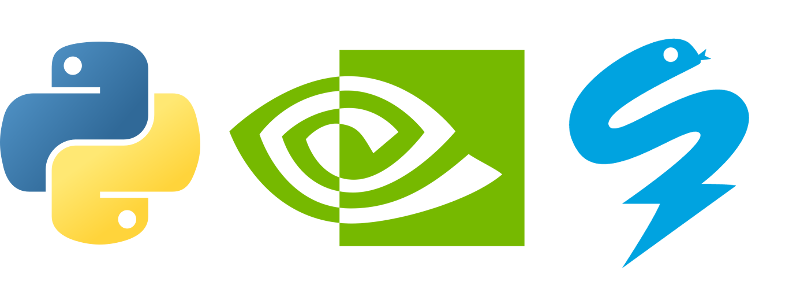
</center>

<h1><center>CUDA by Numba Examples</center></h1>
<h2><center>Part 2 of 4: Threading the Needle</center></h2>
<h3><center>Carlos Costa (<a href="https://github.com/cako">@cako</a>)</center></h3>
<h4><center>July 2022</center></h4>

<hr>

<h3>Introduction</h3>

In the [first installment of this series](https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_1_of_4.ipynb) we discussed how to run embarrassingly parallel algorithms using the GPU. Embarrassingly parallel tasks are those whose tasks are completely independent from each other, such as summing two arrays or applying any element-wise function.

<br>
<h3>In This Tutorial</h3>

Many tasks, although not embarrassingly parallel, can still benefit from parallelization. In this issue of *CUDA by Numba Examples* we will cover some common techniques for allowing threads to cooperate on a computation.

New in this tutorial:
* <code>numba.cuda.shared.array</code>
* <code>numba.cuda.reduce</code>

<center>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_1_of_4.ipynb">Part 1</a>,
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_2_of_4.ipynb">Part 2 (this part)</a>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_3_of_4.ipynb">Part 3</a>
<a href="https://github.com/cako/cuda-by-numba-examples/blob/main/CUDA_by_Numba_Examples_4_of_4.ipynb">Part 4</a>
</center>

---

In [ ]:
!pip install --upgrade numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from time import perf_counter

import numpy as np

import numba
from numba import cuda

print(np.__version__)
print(numba.__version__)

1.21.6
0.55.2


In [ ]:
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-bcc6196e-f26e-afdc-1db3-6eba6ff160f0
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

## Thread Cooperation

#### Simple Parallel Reduction Algorithm

We'll start this section with a very simply problem: summing all elements of an array. Serially, this algorithm is extremely simple. Without resorting to NumPy, we could implement it as:

In [ ]:
def sum_cpu(array):
    s = 0.0
    for i in range(array.size):
        s += array[i]
    return s 

I know, this doesn't look very Pythonic. But it does emphasize that `s` is keeping track of *all* elements in the array. How can we parallelize this algorithm if `s` depends on every element of the array? Well, first, we need to rewrite the algorithm to allow for some parallelization. In the parts we cannot parallelize, we should allow threads to communicate with each other.

So far, however, we have not learned how make threads talk to each other... in fact we stated previously that threads in different blocks do not communicate. We could consider only launching one block only, but remember that blocks can only have 1024 threads in most GPUs!

How do we overcome this? Well, what if we split our array into chunks of 1024 (or an appropriate number of `threads_per_block`) and sum each of those chunks separately? Then at the end, we can just sum the results from the sum of each chunk. Figure 2.1 shows a very simple example of this for a 2-chunk split. 

<center>
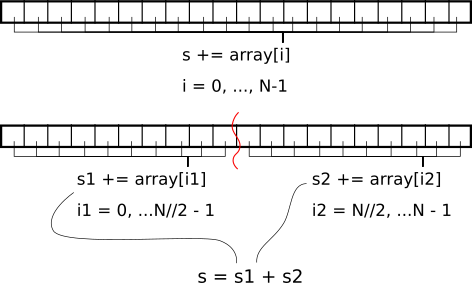
<p>Figure 2.1. A "divide-and-conquer" approach to summing elements of an array. Image by author.
</center>

How do we do this on the GPU? First we need to split the array into chunks. Each chunk will just correspond to a block, with a fixed number of threads. Within each block, each thread may sum more than one array element (grid-stride loop). Then, we must these per-thread values over the entire block. This bit requires threads to communicate. We'll go over how to do that in the next example.

Since we are parallelizing over blocks, the output of the kernel should be sized as a block. To finalize the reduction, we copy this to the CPU and finish the job there.

In [ ]:
threads_per_block = 1024  # Why not!
blocks_per_grid = 32 * 80  # Use 32 * multiple of streaming multiprocessors

In [ ]:
# Example 2.1: Naive reduction
@cuda.jit
def reduce_naive(array, partial_reduction):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of a single the thread into the
    # shared array. Since the shared array is sized
    #     threads_per_block == blockDim.x
    # (1024 in this example), we should index it with `threadIdx.x`.
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    cuda.syncthreads()

    # Finally, we need to sum the values from all threads to yield a single
    # value per block. We only need one thread for this.
    if tid == 0:
        # We store the sum of the elements of the shared array in its first
        # coordinate
        for i in range(1, threads_per_block):
            s_block[0] += s_block[i]
        # Move this partial sum to the output. Only one thread is writing here.
        partial_reduction[cuda.blockIdx.x] = s_block[0]

---
$\color{red}{\textbf{WARNING}}$

The shared array must 

  * Be "small". The exact size depends on the compute capability of the GPU, typically between 48 KB and 163 KB. See item "Maximum amount of shared memory per thread block" in [this table](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#features-and-technical-specifications__technical-specifications-per-compute-capability).
  * Have a known size at compile time (which is why we size our shared array `threads_per_block` and not `blockDim.x`). It is true that we can always define a [factory function](https://en.wikipedia.org/wiki/Factory_(object-oriented_programming)) to shared array of any size... but be wary of compile time for these kernels.
  * Have `dtype` specified by Numba type, not a Numpy type (don't ask me why!).

---

In [ ]:
N = 1_000_000_000
a = np.arange(N, dtype=np.float32)
a /= a.sum() # a will have sum = 1 (to float32 precision)

s_cpu = a.sum()

In [ ]:
# Highly-optimized NumPy CPU code
timing_cpu = np.empty(21)
for i in range(timing_cpu.size):
    tic = perf_counter()
    a.sum()
    toc = perf_counter()
    timing_cpu[i] = toc - tic
timing_cpu *= 1e3  # convert to ms

print(f"Elapsed time CPU: {timing_cpu.mean():.0f} ± {timing_cpu.std():.0f} ms")

Elapsed time CPU: 354 ± 24 ms


In [ ]:
dev_a = cuda.to_device(a)
dev_partial_reduction = cuda.device_array((blocks_per_grid,), dtype=a.dtype)

reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)  # Ensure we have the right number

True

Let's time this little tidbit.

In [ ]:
timing_naive = np.empty(21)
for i in range(timing_naive.size):
    tic = perf_counter()
    reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    s = dev_partial_reduction.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_naive[i] = toc - tic
timing_naive *= 1e3  # convert to ms

print(f"Elapsed time naive: {timing_naive.mean():.0f} ± {timing_naive.std():.0f} ms")

Elapsed time naive: 30 ± 12 ms


On the Google Colab I ran this, we get a 10x speedup. Pretty nice!

### A Better Parallel Reduction Algorithm

You may be wondering now why we named everything "naive". That implies that there is some non-naive way of doing this same function. In fact there are a bunch of tricks to speed up this kind of code (see this great [*Optimizing Parallel Reduction in CUDA*](https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf) presentation for benchmarks).

Before we show a better way of doing this, let us recall the last bit of the kernel:

```python
if tid == 0:  # Single thread taking care of business
    for i in range(1, threads_per_block):
        s_block[0] += s_block[i]
    partial_reduction[cuda.blockIdx.x] = s_block[0]
```

We parallelized almost everything, but at the end of the kernel, we are making a single thread take care of summing all of the `threads_per_block` elements of the shared array `s_block`. Why don't we parallelize this sum as well?

Sounds good, how? Figure 2.2 shows how one can achieve this for a `threads_per_block` size of 16. We start with 8 threads working, the first will sum values in `s_block[0]` and `s_block[8]`. The second, values in `s_block[1]` and `s_block[9]`, until the last thread which will sum values `s_block[7]` and `s_block[15]`.

On the next step, only the first 4 threads need to work. The first thread will sum `s_block[0]` and `s_block[4]`; the second, `s_block[1]` and `s_block[5]`; the third, `s_block[2]` and `s_block[6]`; the fourth and last, `s_block[3]` and `s_block[7]`.

On the third step, we now only need 2 threads, to take care of the first 4 elements of `s_block`. The fourth and final step will use one thread to sum 2 elements.

Since the work has been divided between the threads, it is parallelized. Sure, it is not an equal division by each thread, but it is an improvement. Computationally, this algorithm is $O$(log<sub>2</sub>(`threads_per_block`)), whereas the first algorithm is $O$(`threads_per_block`). In our example, thats 1024 operations for the naive algorithm vs. only 10 for the improved algorithm!

There is one final detail. At every step, we need to ensure that all threads have written to the shared array. So we have to call `cuda.syncthreads()`.

<center>
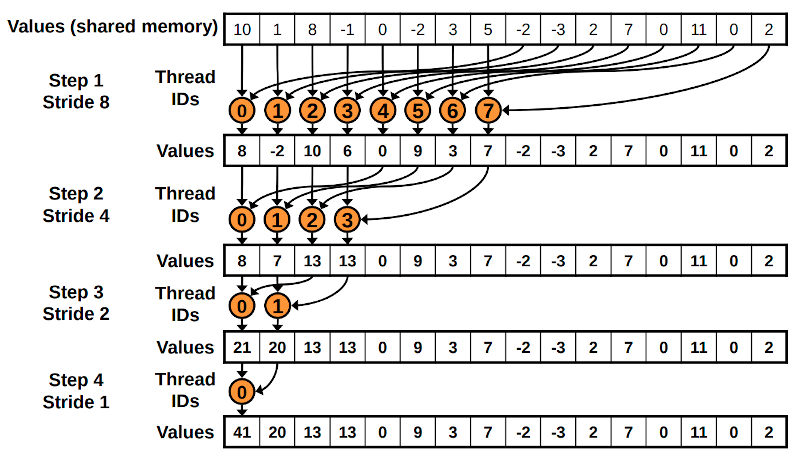
<p>Figure 2.2. Reduction by sequential addressing. Credit: Mark Harris, <a href="https://developer.download.nvidia.com/assets/cuda/files/reduction.pdf"><i>Optimizing Parallel Reduction in CUDA</i></a>.</p>
</center>

In [ ]:
# Example 2.2: Better reduction
@cuda.jit
def reduce_better(array, partial_reduction):
    i_start = cuda.grid(1)
    threads_per_grid = cuda.blockDim.x * cuda.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = cuda.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of the thread into the shared array.
    # Since the shared array is sized threads_per_block == blockDim.x,
    # we should index it with `threadIdx.x`.
    tid = cuda.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while (i > 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        cuda.syncthreads()
        i //= 2

    if tid == 0:
        partial_reduction[cuda.blockIdx.x] = s_block[0]

In [ ]:
reduce_better[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)

True

In [ ]:
timing_naive = np.empty(21)
for i in range(timing_naive.size):
    tic = perf_counter()
    reduce_better[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    s = dev_partial_reduction.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_naive[i] = toc - tic
timing_naive *= 1e3  # convert to ms

print(f"Elapsed time better: {timing_naive.mean():.0f} ± {timing_naive.std():.0f} ms")

Elapsed time better: 22 ± 1 ms


On my machine, this is about 25% faster than the naive method.

---
$\color{red}{\textbf{WARNING}}$

You may be tempted to move `syncthreads` to inside the `if` block, since after every step, kernels beyond half of current number of threads will not be used.
However, doing this will make CUDA threads which called `syncthreads` to stop and wait for all others, whereas all the other ones will just keep going. Consequently, the stopped threads will be forever waiting for threads that will never stop to synchronize. The takeaway is: if you syncthronize threads, ensure that **`cuda.syncthreads()` is called in all threads**.

```python
i = cuda.blockDim.x // 2
while (i > 0):
    if (tid < i):
        s_block[tid] += s_block[tid + i]
        cuda.syncthreads() # don't put it here
    cuda.syncthreads()  # instead of here
    i //= 2
```

---

### Numba Reduce

Because the above reduction algorithm is non-trivial, Numba offers a convenience `cuda.reduce` decorator that converts a binary function into a reduction. The long and complex algorithm above can then be substituted by:

In [ ]:
    # Example 2.3: Numba reduction
    @cuda.reduce
    def reduce_numba(a, b):
        return a + b

In [ ]:
# Compile and check
s = reduce_numba(dev_a)

np.isclose(s, s_cpu)

/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


True

In [ ]:
# Time
timing_numba = np.empty(21)
for i in range(timing_numba.size):
    tic = perf_counter()
    s = reduce_numba(dev_a)
    toc = perf_counter()
    assert np.isclose(s, s_cpu)    
    timing_numba[i] = toc - tic
timing_numba *= 1e3  # convert to ms

print(f"Elapsed time better: {timing_numba.mean():.0f} ± {timing_numba.std():.0f} ms")

/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Elapsed time better: 45 ± 0 ms


Personally, I have found that hand-written reductions are generally much faster (2x at least), but Numba recursions are dead easy to use. With that said, I would encourage reading over the [reduction code in the Numba source code](https://github.com/numba/numba/blob/main/numba/cuda/kernels/reduction.py).

It is also important to note that by default, the reduction copies to host, which forces a synchronization. To avoid this, you can call the reduction with a device array as output:

In [ ]:
dev_s = cuda.device_array((1,), dtype=s)

reduce_numba(dev_a, res=dev_s)

s = dev_s.copy_to_host()[0]
np.isclose(s, s_cpu)

/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (64) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (80) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


True

### 2D Reduction Example

The parallel reduction technique is great, but it is not obvious how it can be extended to higher dimensions. While we can always call the Numba reduction with an unravelled array (`array2d.ravel()`), it is important to understand how we can reduce multidimensional arrays manually.

In this example, we will combine what we learned about 2D kernels with what we learned about 1D reductions to compute a 2D reduction.

In [ ]:
threads_per_block_2d = (16, 16)  #  256 threads total
blocks_per_grid_2d = (64, 64)

# Total number of threads in a 2D block (has to be an int)
shared_array_len = int(np.prod(threads_per_block_2d))  

In [ ]:
# Example 2.4: 2D reduction with 1D shared array
@cuda.jit
def reduce2d(array2d, partial_reduction2d):
    ix, iy = cuda.grid(2)
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2)

    s_thread = 0.0
    for i0 in range(iy, array2d.shape[0], threads_per_grid_x):
        for i1 in range(ix, array2d.shape[1], threads_per_grid_y):
            s_thread += array2d[i0, i1]

    # Allocate shared array
    s_block = cuda.shared.array(shared_array_len, numba.float32)

    # Index the threads linearly: each tid identifies a unique thread in the
    # 2D grid.
    tid = cuda.threadIdx.x + cuda.blockDim.x * cuda.threadIdx.y
    s_block[tid] = s_thread

    cuda.syncthreads()

    # We can use the same smart reduction algorithm by remembering that
    #     shared_array_len == blockDim.x * cuda.blockDim.y
    # So we just need to start our indexing accordingly.
    i = (cuda.blockDim.x * cuda.blockDim.y) // 2
    while (i != 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        cuda.syncthreads()
        i //= 2
    
    # Store reduction in a 2D array the same size as the 2D blocks
    if tid == 0:
        partial_reduction2d[cuda.blockIdx.x, cuda.blockIdx.y] = s_block[0]

In [ ]:
N_2D = (20_000, 20_000)
a_2d = np.arange(np.prod(N_2D), dtype=np.float32).reshape(N_2D)
a_2d /= a_2d.sum() # a_2d will have sum = 1 (to float32 precision)

s_2d_cpu = a_2d.sum()

In [ ]:
dev_a_2d = cuda.to_device(a_2d)
dev_partial_reduction_2d = cuda.device_array(blocks_per_grid_2d, dtype=a.dtype)

reduce2d[blocks_per_grid_2d, threads_per_block_2d](dev_a_2d, dev_partial_reduction_2d)
s_2d = dev_partial_reduction_2d.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s_2d, s_2d_cpu)  # Ensure we have the right number

True

In [ ]:
timing_2d = np.empty(21)
for i in range(timing_2d.size):
    tic = perf_counter()
    reduce2d[blocks_per_grid_2d, threads_per_block_2d](dev_a_2d, dev_partial_reduction_2d)
    s_2d = dev_partial_reduction_2d.copy_to_host().sum()
    cuda.synchronize()
    toc = perf_counter()
    assert np.isclose(s_2d, s_2d_cpu)    
    timing_2d[i] = toc - tic
timing_2d *= 1e3  # convert to ms

print(f"Elapsed time better: {timing_2d.mean():.0f} ± {timing_2d.std():.0f} ms")

Elapsed time better: 15 ± 4 ms


## Device functions

So far we have only talked about kernels, which are special GPU functions that launch threads. Kernels often rely on smaller functions, defined in the GPU and which only have access to GPU arrays. These are called *device functions*. Differently from kernels, they can return values.

To end this part of the tutorial, we will show an example of using a device function across different kernels. The example will also stress how important it is to synchronize threads when using shared arrays.

---
$\color{Goldenrod}{\textbf{INFO}}$

In newer CUDA versions, it is possible for kernels to launch other kernels. This is called dynamic parallelism and is not yet supported by Numba CUDA.

---

### 2D Shared Array Example

In this example, we will create a ripple pattern in a fixed-size array. We first need to declare the number of threads we will use as this is required by the shared array.

In [ ]:
threads_16 = 16

In [ ]:
import math

@cuda.jit(device=True, inline=True)  # inlining can speed up execution
def amplitude(ix, iy):
    return (1 + math.sin(2 * math.pi * (ix - 64) / 256)) * (
        1 + math.sin(2 * math.pi * (iy - 64) / 256)
    )

# Example 2.5a: 2D Shared Array
@cuda.jit
def blobs_2d(array2d):
    ix, iy = cuda.grid(2)
    tix, tiy = cuda.threadIdx.x, cuda.threadIdx.y

    shared = cuda.shared.array((threads_16, threads_16), numba.float32)
    shared[tiy, tix] = amplitude(iy, ix)
    cuda.syncthreads()

    array2d[iy, ix] = shared[15 - tiy, 15 - tix]

# Example 2.5b: 2D Shared Array without synchronize
@cuda.jit
def blobs_2d_wrong(array2d):
    ix, iy = cuda.grid(2)
    tix, tiy = cuda.threadIdx.x, cuda.threadIdx.y

    shared = cuda.shared.array((threads_16, threads_16), numba.float32)
    shared[tiy, tix] = amplitude(iy, ix)

    # When we don't sync threads, we may have not written to shared
    # yet, or even have overwritten it by the time we write to array2d
    array2d[iy, ix] = shared[15 - tiy, 15 - tix]

In [ ]:
N_img = 1024
blocks = (N_img // threads_16, N_img // threads_16)
threads = (threads_16, threads_16)

dev_image = cuda.device_array((N_img, N_img), dtype=np.float32)
dev_image_wrong = cuda.device_array((N_img, N_img), dtype=np.float32)

blobs_2d[blocks, threads](dev_image)
blobs_2d_wrong[blocks, threads](dev_image_wrong)

image = dev_image.copy_to_host()
image_wrong = dev_image_wrong.copy_to_host()

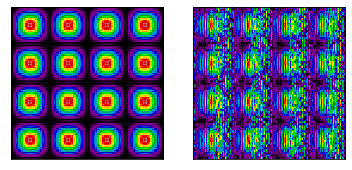

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image.T, cmap="nipy_spectral")
ax2.imshow(image_wrong.T, cmap="nipy_spectral")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])


## Conclusion
In this tutorial you learned how to develop kernels that required a reduction pattern to process 1D and 2D arrays. In the process we learned how to exploit shared arrays and device functions.